# Roman Redshift Analysis

## Roman Parameters and Requirements
https://roman.gsfc.nasa.gov/science/technical_resources.html

## Table of Contents

1. Setup
    1. [Import Python modules](#Import-Python-modules)  
    2. [Python Helper Functions](#Python-Helper-Functions)
    3. [Path to my simulation directories](#Path-to-my-simulation-directories)
2. [Read SExtractor Photometry of Direct Images](#Read-SExtractor-Photometry-of-Direct-Images)
3. [Check simulation](#Check-simulation)
4. [Inspect Redshift Fitting Results](#Inspect-Redshift-Fitting-Results)

[top](#Table-of-Contents)

In [1]:
%matplotlib inline

In [ ]:
import importlib
importlib.reload(grizli_analysis)

In [ ]:
import importlib
importlib.reload(grizli_functions)

## Import Python modules
[top](#Table-of-Contents)

In [2]:
import os,sys
import glob
from collections import OrderedDict

import matplotlib as mpl    
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (10.0, 6.0)
mpl.rcParams['font.size'] = 16
mpl.rcParams['savefig.dpi'] = 72

#from IPython.display import Image

import numpy as np

import astropy
import astropy.io.fits as pyfits
from astropy.table import Table, join, vstack
import astropy.units as u
from astropy.coordinates import SkyCoord

import time
import pickle
import gc

from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MultipleLocator
import matplotlib.ticker as ticker

print('\n Python version: ', sys.version)
print('\n Astropy version: ', astropy.__version__)


 Python version:  3.9.12 (main, Jun  1 2022, 11:38:51) 
[GCC 7.5.0]

 Astropy version:  5.1


In [3]:
import grizli
from grizli import multifit
print('\n Grizli version: ', grizli.__version__)


 Grizli version:  1.5.1.dev126


In [4]:
import grizli_analysis
from grizli_analysis import display_grizli
from grizli_analysis import check_primers
from grizli_analysis import check_all_phot, check_all_redshift_fits
from grizli_analysis import check_roll_phot, check_roll_redshift_fits
from grizli_analysis import build_all_tables, build_roll_tables
from grizli_analysis import plot_redshifts, plot_redshifts2
from grizli_analysis import sample_numbers, sample_numbers2, sample_numbers3
from grizli_analysis import emline_bar_chart, emline_bar_chart2
from grizli_analysis import sn_dz_plot, sn_dz_hist2d_plot

In [ ]:
dir()

## Python Helper Functions

These will eventually be replaced by grizli_functions library

In [ ]:
def display_grizli(root, id, w0=0.8, w1=1.7, labels=1, y0=-1, y1=-1, z_in=0):
    
    # constants
    fontsize = 8
    #y0 = -1e-18
    #y1 = 3.5e-18
    lw = 2
    

    f_full = '{0}_{1:05d}.full.fits'.format(root, id)
    #print(f_full)
    full_hdu = pyfits.open(f_full)
    #print(full_hdu.info())
    head = full_hdu[0].header
    zfit_stack = Table(full_hdu['ZFIT_STACK'].data)
    zfit_head = full_hdu['ZFIT_STACK'].header
    templ = Table(full_hdu['TEMPL'].data)
    print()
    
    #print(head)
    ndfilts = head["NDFILT"] # number of direct image filters
    for i in range(ndfilts):
        print(head["DFILT%02d" % (i+1)])
        
        direct = full_hdu[5+(2*i)].data
        #print(direct)
        #print(direct.shape)    
    
    #head["REDSHIFT"] # redshift
    #head["NUMLINES"] # number of emission lines
    

    f_1d = '{0}_{1:05d}.1D.fits'.format(root, id)
    #print(f_1d)
    oned_hdu = pyfits.open(f_1d)
    #print(oned_hdu[1].header)
    print(oned_hdu.info())
    grism = Table(oned_hdu['GRISM'].data)
    grism.show_in_notebook()
    print(grism.colnames)
    #print()
    
    
    
    f_2d = '{0}_{1:05d}.stack.fits'.format(root, id)
    #print(f_2d)
    twod_hdu = pyfits.open(f_2d)
    #print(twod_hdu.info())
    #print()

    
    fig = plt.figure(figsize=(12,10))
    #           row column
    gs = GridSpec(3, 4, hspace=0.4)

    p1 = fig.add_subplot(gs[:1, 0:2])
    p2 = fig.add_subplot(gs[:1, 2:])
    p3 = fig.add_subplot(gs[1, :])
    p4 = fig.add_subplot(gs[2, :])


    # Z_MAP, CHIMIN and DOF
    
    p1.text(0.95, 0.96, root + '\n'+'ID={0:<5d}  z={1:.4f}'.format(id, zfit_head['z_map']), ha='right', va='top', transform=p1.transAxes, fontsize=9)

    zmi, zma = zfit_stack['zgrid'].min(), zfit_stack['zgrid'].max()
    if (zma-zmi) > 5:
        ticks = np.arange(np.ceil(zmi), np.floor(zma)+0.5, 1)
        lz = np.log(1+zfit_stack['zgrid'])
        p1.plot(lz, np.log10(zfit_stack['pdf']), color='k')
        p1.set_xticks(np.log(1+ticks))
        p1.set_xticklabels(np.cast[int](ticks))
        p1.set_xlim(lz.min(), lz.max())
    else:
        p1.plot(zfit_stack['zgrid'], np.log10(zfit_stack['pdf']), color='k')
        p1.set_xlim(zmi, zma)

    p1.set_xlabel(r'$z$')
    p1.set_ylabel(r'$\log\ p(z)$'+' / '+ r'$\chi^2=\frac{{{0:.0f}}}{{{1:d}}}={2:.2f}$'.format(zfit_head['chimin'], zfit_head['DoF'], zfit_head['chimin']/zfit_head['DoF']))
    p1.set_yticks([1,4,9,16,25])

    pzmax = np.log10(zfit_stack['pdf'].max())
    p1.set_ylim(pzmax-6, pzmax+0.9)
    p1.grid()
    p1.yaxis.set_major_locator(MultipleLocator(base=1))
    
    
    
    #pz_max = np.log10(zfit_stack['pdf'].max())
    
    #p1.plot(zfit_stack['zgrid'], np.log10(zfit_stack['pdf']), label='Stacked')
    #p1.set_xlim(0.0, 3); 
    ##p1.semilogy(); 
    #p1.grid()
    ##p1.set_ylim(1.e-50, 1e4)
    #p1.set_ylim(pz_max-6, pz_max+0.9)
    #p1.set_xlabel('z'); p1.set_ylabel('PDF(z)'); #plt.legend()

    p2.plot(zfit_stack['zgrid'], zfit_stack['risk'], label='Stacked')
    p2.set_xlim(0.0, 3); p2.semilogy(); p2.grid()
    p2.set_xlabel('z'); p2.set_ylabel('risk'); #p3.legend()
    
    #print('Continuum template, cont1d: ', templ['continuum'].__class__)
    #print(templ.colnames)
    
    
    if y0 < 0: y0 = np.min(templ['continuum'] + templ['full'])
    if y1 < 0: y1 = np.max(templ['continuum'] + templ['full'])
    
    
    p3.plot(templ['wave']/1.e4, templ['continuum'], label='continuum')
    p3.plot(templ['wave']/1.e4, templ['full'], label='total')
    p3.set_xlim(w0, w1); p3.set_ylim(y0,y1);#p3.set_ylim(0,1.e-17) 
    p3.grid()
    p3.set_xlabel(r'$\lambda$ (microns)')
    p3.set_ylabel(r'F$_\lambda$ (erg/s/cm$^2$/$\AA$)')
    #p3.legend()
    
    
    
    if z_in: z0 = z_in
    else: z0 = zfit_head['z_map']
        
    #z0 = zfit_head['z_map']
       
    for line,wemit in emlines:
        wobs = (1+z0)*wemit
        #FWHM = vel * wobs / c_km
        if wobs/1e4 > w0 and wobs/1e4 < w1:

            p4.plot([wobs/1e4,wobs/1e4],[y0,y1],":",lw=lw,c="b")
        
            if labels:
                p4.text(wobs/1e4,0.7*y1,line,fontsize=fontsize,
                        rotation='vertical',
                        horizontalalignment='center',
                        verticalalignment='center')
                
    
    p4.errorbar(grism['wave']/1e4, grism['flux']/grism['flat'], yerr=grism["err"]/grism['flat'], 
                color="g", marker='.', linestyle='None', alpha=0.5) 
                
    p4.plot(grism['wave']/1e4, grism['line']/grism['flat'], color="r", alpha=0.5)  
    
    p4.plot(grism['wave']/1e4, grism['contam']/grism['flat'], color="b", alpha=0.5)
    
    p4.set_xlim(w0, w1); p4.set_ylim(y0,y1);
    #p4.semilogy(); 
    p4.grid()
    p4.set_xlabel(r'$\lambda$ (microns)')
    p4.set_ylabel(r'F$_\lambda$ (erg/s/cm$^2$/$\AA$)')
    
    # Gabe's routine
    multifit.show_drizzle_HDU(twod_hdu)
    

In [5]:
root = "sim_v3"
HOME_PATH = "/home/gwalth/data/Roman/grizli/sims"
LOCAL_PATH = "/local/RomanSims/grizli/sims"

In [ ]:
#check_all_primer()
check_primers(root=root, HOME_PATH=HOME_PATH, LOCAL_PATH=LOCAL_PATH, PREP_PATH = "Prep/",
              glob_dir="field*")

In [ ]:
check_all_phot(glob_dir="field*")

In [ ]:
check_all_redshift_fits(glob_dir="field*")

Time to process all tables 4604 seconds (1.3 hours)

In [ ]:
all_match_tables,all_match_clean_tables = build_all_tables()

In [ ]:
all_match_tbl = vstack(all_match_tables)
all_match_clean_tbl = vstack(all_match_clean_tables)

### Write tables

In [6]:
print(os.getcwd())

/home/gwalth/data/Roman/grizli/notebooks


In [7]:
LOCAL_PATH = "/local/RomanSims/grizli/sims"
root = "sim_v3"

print(os.getcwd())
os.chdir(os.path.join(LOCAL_PATH, root, 'Extraction'))
print(os.getcwd())

/home/gwalth/data/Roman/grizli/notebooks
/local/RomanSims/grizli/sims/sim_v3/Extraction


In [ ]:
all_match_tbl.write("combined_match.fits", overwrite=True)
all_match_clean_tbl.write("combined_match_clean.fits", overwrite=True)

### Load tables

In [8]:
#from astropy.table import Table
all_match_tbl = Table.read("combined_match.fits")
all_match_clean_tbl = Table.read("combined_match_clean.fits")

In [9]:
print(all_match_tbl)

 ID   X_IMAGE   Y_IMAGE  ...       flux_OIII                 d2d          
        pix       pix    ...                                 deg          
---- --------- --------- ... ---------------------- ----------------------
   5  440.5134    2.7851 ... 5.4047558150598913e-20 0.00018605365624215474
   6  427.5729    3.3481 ... 3.3941884332851645e-18  0.0006903270446360118
  19  430.4201   13.9061 ...   2.21305629935042e-18  0.0009124744550529089
  27  455.8208    9.5553 ... 1.3019177313738077e-19    0.00134933562872183
  34  456.2797   16.9594 ... 1.4325984954795252e-17  0.0005469854063069802
  42  440.2504   52.5133 ...  8.940461181984579e-21  0.0005347210721725376
 ...       ...       ... ...                    ...                    ...
9512  1947.672 3989.8445 ... 2.7585022223401574e-18   0.001470369540060956
9512  1947.672 3989.8445 ... 2.0988575916855933e-18   6.65232625390863e-06
9525 1910.1434 4012.6484 ...  5.063445850729386e-19  5.772710524548752e-05
9525 1910.1434 4012.6484 

In [10]:
print(all_match_tbl['FLUX001'])

      FLUX001       
--------------------
1.61877602295842e-16
 5.6232940116215e-17
1.53368739422177e-15
5.48064390322703e-15
6.35083044633451e-17
1.67091851739108e-16
                 ...
4.88448120013284e-17
1.81609067818893e-17
1.81609067818893e-17
2.84203042365896e-17
2.84203042365896e-17
4.69305394940398e-17
3.73738130017076e-17
Length = 340387 rows


In [11]:
print(all_match_clean_tbl)

 ID   X_IMAGE   Y_IMAGE  ...       flux_OIII                 d2d          
        pix       pix    ...                                 deg          
---- --------- --------- ... ---------------------- ----------------------
  44  492.6235   59.9983 ... 1.0825511854504777e-17  8.491509923085992e-05
  45  494.9708   69.4281 ... 2.6869707969190705e-18  8.934242253234742e-05
  48  1167.512   83.7241 ... 1.5276047387394958e-20 4.5378352576529257e-05
  49 1064.3413   77.6749 ...  5.676548046305399e-20 4.1362830464140165e-05
  51 1825.4652   84.5028 ... 2.5064608959587444e-18 3.3280247942992546e-05
  52 3591.9663   78.1796 ...   4.38364140959097e-18  3.939070678889149e-05
 ...       ...       ... ...                    ...                    ...
9507  991.0493 4025.1831 ... 2.6506327034181854e-17 3.8561595022063426e-05
9508 1674.3569 4015.1499 ...  5.710350170656656e-18  4.443879763432852e-05
9510 3899.2695 4016.5615 ...   2.53248100043773e-18  4.282561078411568e-05
9512  1947.672 3989.8445 

In [12]:
print(all_match_tbl.colnames)
print(len(all_match_tbl.colnames))

['ID', 'X_IMAGE', 'Y_IMAGE', 'X_WORLD', 'Y_WORLD', 'A_IMAGE', 'B_IMAGE', 'THETA_IMAGE', 'A_WORLD', 'B_WORLD', 'THETA_WORLD', 'FLUX_APER', 'FLUX_APER_1', 'FLUX_APER_2', 'FLUX_APER_3', 'FLUX_APER_4', 'FLUX_APER_5', 'FLUX_APER_6', 'FLUX_APER_7', 'FLUX_APER_8', 'FLUX_APER_9', 'FLUX_APER_10', 'FLUX_APER_11', 'FLUX_APER_12', 'FLUX_APER_13', 'FLUXERR_APER', 'FLUXERR_APER_1', 'FLUXERR_APER_2', 'FLUXERR_APER_3', 'FLUXERR_APER_4', 'FLUXERR_APER_5', 'FLUXERR_APER_6', 'FLUXERR_APER_7', 'FLUXERR_APER_8', 'FLUXERR_APER_9', 'FLUXERR_APER_10', 'FLUXERR_APER_11', 'FLUXERR_APER_12', 'FLUXERR_APER_13', 'FLUX_AUTO', 'FLUXERR_AUTO', 'MAG_AUTO', 'MAGERR_AUTO', 'MAG_BEST', 'MAGERR_BEST', 'KRON_RADIUS', 'PETRO_RADIUS', 'BACKGROUND', 'THRESHOLD', 'ERRA_IMAGE', 'ERRB_IMAGE', 'ERRTHETA_IMAGE', 'ERRA_WORLD', 'ERRB_WORLD', 'ERRTHETA_WORLD', 'XWIN_IMAGE', 'YWIN_IMAGE', 'AWIN_IMAGE', 'BWIN_IMAGE', 'THETAWIN_IMAGE', 'ERRAWIN_IMAGE', 'ERRBWIN_IMAGE', 'ERRTHETAWIN_IMAGE', 'MU_THRESHOLD', 'FLAGS', 'FWHM_IMAGE', 'FLUX_RA

In [13]:
print(all_match_clean_tbl.colnames)
print(len(all_match_clean_tbl.colnames))

['ID', 'X_IMAGE', 'Y_IMAGE', 'X_WORLD', 'Y_WORLD', 'A_IMAGE', 'B_IMAGE', 'THETA_IMAGE', 'A_WORLD', 'B_WORLD', 'THETA_WORLD', 'FLUX_APER', 'FLUX_APER_1', 'FLUX_APER_2', 'FLUX_APER_3', 'FLUX_APER_4', 'FLUX_APER_5', 'FLUX_APER_6', 'FLUX_APER_7', 'FLUX_APER_8', 'FLUX_APER_9', 'FLUX_APER_10', 'FLUX_APER_11', 'FLUX_APER_12', 'FLUX_APER_13', 'FLUXERR_APER', 'FLUXERR_APER_1', 'FLUXERR_APER_2', 'FLUXERR_APER_3', 'FLUXERR_APER_4', 'FLUXERR_APER_5', 'FLUXERR_APER_6', 'FLUXERR_APER_7', 'FLUXERR_APER_8', 'FLUXERR_APER_9', 'FLUXERR_APER_10', 'FLUXERR_APER_11', 'FLUXERR_APER_12', 'FLUXERR_APER_13', 'FLUX_AUTO', 'FLUXERR_AUTO', 'MAG_AUTO', 'MAGERR_AUTO', 'MAG_BEST', 'MAGERR_BEST', 'KRON_RADIUS', 'PETRO_RADIUS', 'BACKGROUND', 'THRESHOLD', 'ERRA_IMAGE', 'ERRB_IMAGE', 'ERRTHETA_IMAGE', 'ERRA_WORLD', 'ERRB_WORLD', 'ERRTHETA_WORLD', 'XWIN_IMAGE', 'YWIN_IMAGE', 'AWIN_IMAGE', 'BWIN_IMAGE', 'THETAWIN_IMAGE', 'ERRAWIN_IMAGE', 'ERRBWIN_IMAGE', 'ERRTHETAWIN_IMAGE', 'MU_THRESHOLD', 'FLAGS', 'FWHM_IMAGE', 'FLUX_RA

### Description of tables

The available tables for analysis:

| Tables      | Description |
| :--- | :--- |
| phot          | SExtractor table |
| Roman         | Grizli data |
| Roman_all     | output of check_sims, all sources |
| Roman_magcut  | output of check_sims, only sources above the magnitude cut |
| Roman_extract | output of check_sims, only sources extracted |
| redshift_fits | all the redshift fits of the Roman_extract (full.fits) read into a table |
| primer        | original input sources and true redshifts |


Roman_extract, redshift_fits and primer need to be joined into one table

Roman_extract and redshift_fits can be joined based on SExtractor id --> all_tbl
primer needs to be joined based on RA,Dec  

| Tables      | Description |
| :--- | :--- |
| all_tbl         | join between Roman_extract and redshift_fits |
| match_tbl       | join between all_tbl and primer |
| match_clean_tbl | sources outside of match radius removed (>0.4") |

83507
29822
20846


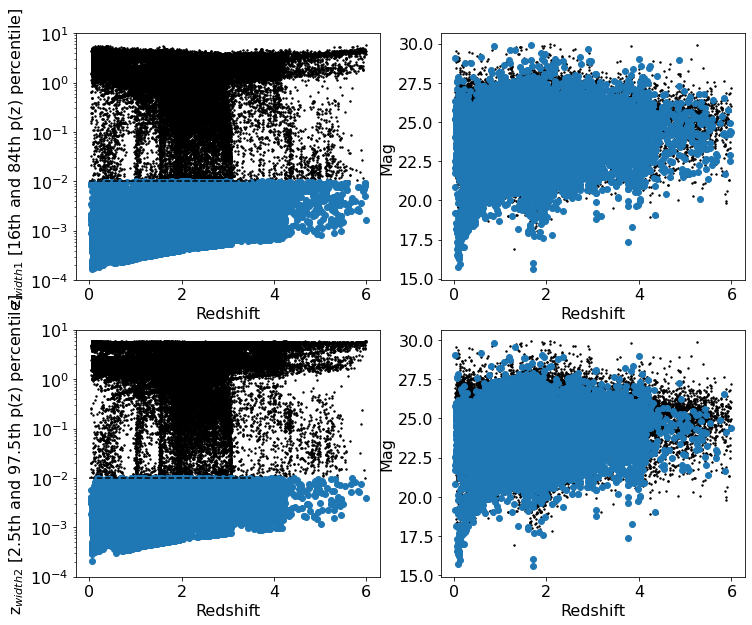

In [14]:
#plot_redshifts(all_tbl)
zfilt1,zfilt2 = plot_redshifts2(all_match_clean_tbl, mag_key="MAG_AUTO")

In [15]:
#z_fit = all_match_clean_tbl["REDSHIFT_1"]
#z_true = all_match_clean_tbl["REDSHIFT_2"]
z_fit = all_match_clean_tbl["REDSHIFT"]
z_true = all_match_clean_tbl["z_true"]

mag_fit  = all_match_clean_tbl["MAG_AUTO"]
#mag_true = all_match_clean_tbl["MAG_F1600W"]
#mag_true = all_match_clean_tbl["m"]
mag_true = all_match_clean_tbl["m_new"]

filt = all_match_clean_tbl["MAG_AUTO"] < 24

Text(0.5, 0, 'Magnitude')

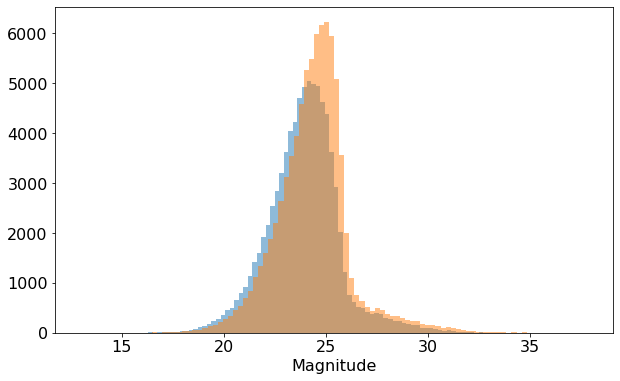

In [16]:
fig = plt.figure()
p1 = fig.add_subplot(111)
p1.hist(all_match_clean_tbl["m"],bins=100, alpha=0.5)
p1.hist(all_match_clean_tbl["m_new"],bins=100, alpha=0.5)
p1.set_xlabel("Magnitude")

Text(0.5, 0, 'True redshift')

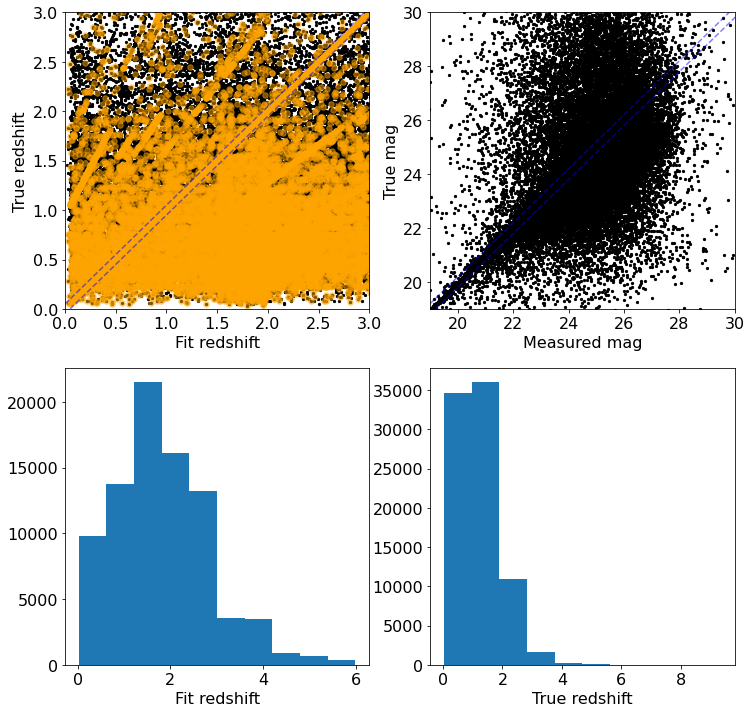

In [17]:
fig = plt.figure(figsize=(12,12))

p1 = fig.add_subplot(221)
p1.scatter(z_fit, z_true, s=5, c="k")
p1.scatter(z_fit[filt], z_true[filt], s=30, c="orange",alpha=0.5)
p1.plot([0.05,3.05],[0.0,3.0],"--",c="b",alpha=0.5)
p1.plot([0.0,3.0],[0.05,3.05],"--",c="b",alpha=0.5)
p1.set_xlim(0,3)
p1.set_ylim(0,3)
p1.set_xlabel("Fit redshift")
p1.set_ylabel("True redshift")

p2 = fig.add_subplot(222)
p2.scatter(mag_fit, mag_true, s=5, c="k")
p2.plot([19.2,30.2],[19,30],"--",c="b",alpha=0.5)
p2.plot([19,30],[19.2,30.2],"--",c="b",alpha=0.5)
p2.set_xlim(19,30)
p2.set_ylim(19,30)
p2.set_xlabel("Measured mag")
p2.set_ylabel("True mag")

p3 = fig.add_subplot(223)
p3.hist(z_fit)
p3.set_xlabel("Fit redshift")

p4 = fig.add_subplot(224)
p4.hist(z_true)
p4.set_xlabel("True redshift")

Text(0.5, 0, 'True redshift')

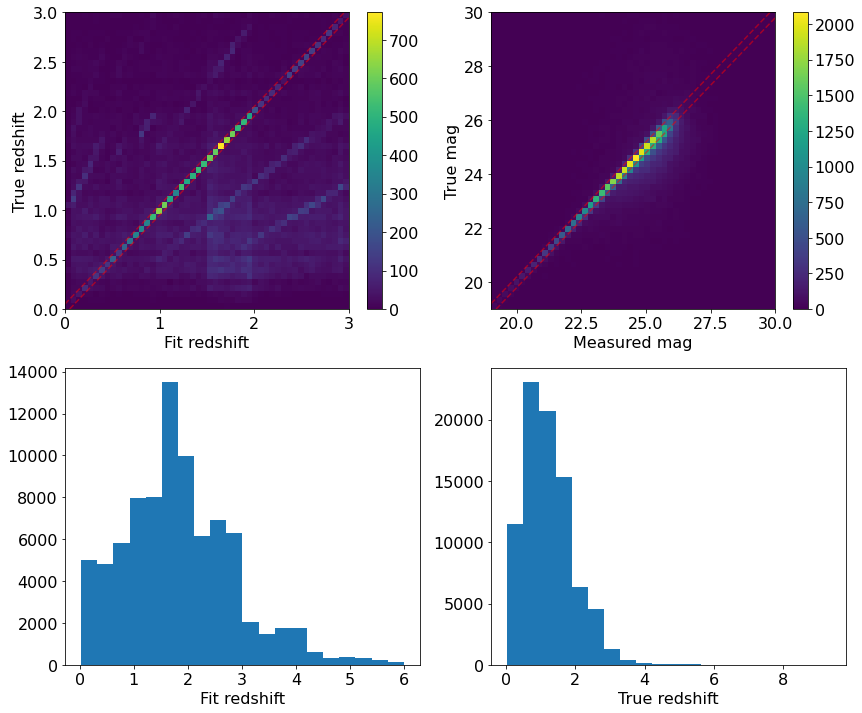

In [18]:
fig = plt.figure(figsize=(14,12))

p1 = fig.add_subplot(221)
#p1.scatter(z_fit, z_true, s=5, c="k")
#p1.scatter(z_fit[filt], z_true[filt], s=30, c="orange",alpha=0.5)
#im1 = p1.hist2d(z_fit,z_true,bins=(60,60))
im1 = p1.hist2d(z_fit, z_true, range=[[0,3],[0,3]], bins=(50,50))
p1.plot([0.05,3.05],[0.0,3.0],"--",c="r",alpha=0.5)
p1.plot([0.0,3.0],[0.05,3.05],"--",c="r",alpha=0.5)
#p1.set_xlim(0,3)
#p1.set_ylim(0,3)
p1.set_xlabel("Fit redshift")
p1.set_ylabel("True redshift")

cb1 = fig.colorbar(im1[3])

p2 = fig.add_subplot(222)
#p2.scatter(mag_fit, mag_true, s=5, c="k")
#im2 = p2.hist2d(mag_fit, mag_true, bins=(55,55))
im2 = p2.hist2d(mag_fit, mag_true, range=[[19,30],[19,30]], bins=(50,50))
p2.plot([19.2,30.2],[19,30],"--",c="r",alpha=0.5)
p2.plot([19,30],[19.2,30.2],"--",c="r",alpha=0.5)
#p2.set_xlim(19,30)
#p2.set_ylim(19,30)
p2.set_xlabel("Measured mag")
p2.set_ylabel("True mag")

cb2 = fig.colorbar(im2[3])

p3 = fig.add_subplot(223)
p3.hist(z_fit,bins=20)
p3.set_xlabel("Fit redshift")

p4 = fig.add_subplot(224)
p4.hist(z_true,bins=20)
p4.set_xlabel("True redshift")

Text(0.5, 0, 'dz')

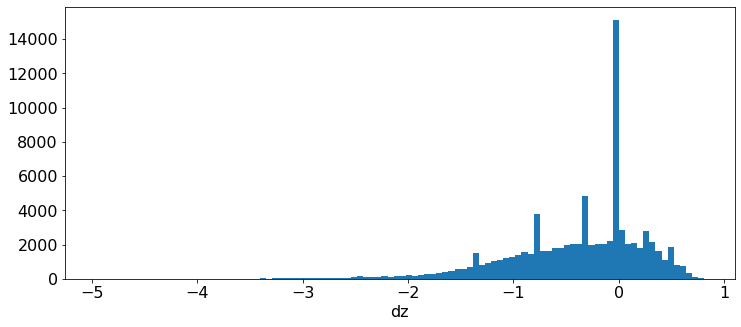

In [19]:
dz = (z_true - z_fit)/(1+z_true)

fig = plt.figure(figsize=(12,5))

p1 = fig.add_subplot(111)
p1.hist(dz,bins=100)

#p1.hist(dz,bins=1000)
#p1.set_xlim(-0.02,0.02)

p1.set_xlabel("dz")

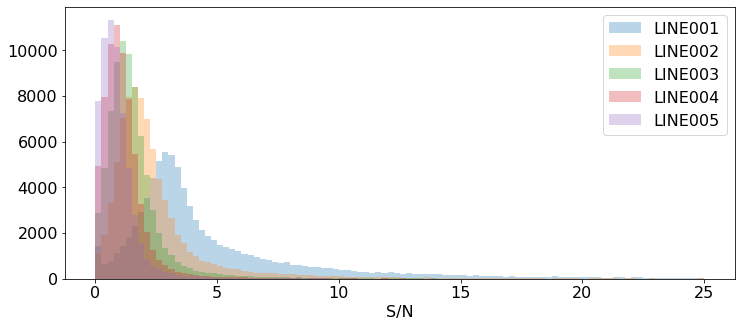

In [20]:
all_match_clean_tbl['SN001'] = all_match_clean_tbl['FLUX001']/all_match_clean_tbl['ERR001']
all_match_clean_tbl['SN002'] = all_match_clean_tbl['FLUX002']/all_match_clean_tbl['ERR002']
all_match_clean_tbl['SN003'] = all_match_clean_tbl['FLUX003']/all_match_clean_tbl['ERR003']
all_match_clean_tbl['SN004'] = all_match_clean_tbl['FLUX004']/all_match_clean_tbl['ERR004']
all_match_clean_tbl['SN005'] = all_match_clean_tbl['FLUX005']/all_match_clean_tbl['ERR005']

fig = plt.figure(figsize=(12,5))
p1 = fig.add_subplot(111)
p1.hist(all_match_clean_tbl['SN001'],bins=100,range=[0,25],label="LINE001",alpha=0.3)
p1.hist(all_match_clean_tbl['SN002'],bins=100,range=[0,25],label="LINE002",alpha=0.3)
p1.hist(all_match_clean_tbl['SN003'],bins=100,range=[0,25],label="LINE003",alpha=0.3)
p1.hist(all_match_clean_tbl['SN004'],bins=100,range=[0,25],label="LINE004",alpha=0.3)
p1.hist(all_match_clean_tbl['SN005'],bins=100,range=[0,25],label="LINE005",alpha=0.3)
p1.set_xlabel("S/N")
#p1.set_xlim(0,25)
p1.legend()

In [21]:
filt1 = all_match_clean_tbl['SN001'] > 6.5
print("Num. sources (S/N > 6.5) =",len(all_match_clean_tbl['SN001'][filt1]))

all_match_clean_sn65_tbl = all_match_clean_tbl[filt1]
print("Num. sources w/ 2 lines (S/N > 3)")
filt2 = all_match_clean_sn65_tbl['SN002'] > 3
print(len(all_match_clean_sn65_tbl[filt2]))

print("Num. sources w/ 3 lines (S/N > 3)")
filt3 = all_match_clean_sn65_tbl['SN003'] > 3
print(len(all_match_clean_sn65_tbl[filt3]))



Num. sources (S/N > 6.5) = 18832
Num. sources w/ 2 lines (S/N > 3)
8322
Num. sources w/ 3 lines (S/N > 3)
3712


In [37]:
def sample_numbers4(tbl, sn_key='SN001', sn=6.5, sigma_dz=0.005, bin_size=0.1, zmin=0, zmax=6,
                    alpha=1.0, weights=None, full_output=0, label = "all", label_dz = "z < 0.005",
                    ax=""):

    print('All sources =',len(tbl[sn_key]))

    filt = (tbl[sn_key] > sn) & (tbl["REDSHIFT"] >= zmin) & (tbl["REDSHIFT"] <= zmax)
    
    print()
    print('Num. sources (S/N > %.1f, %.1f < z < %.1f) =' % (sn,zmin,zmax),len(tbl[sn_key][filt]))

    z_fit = tbl["REDSHIFT"][filt] # sn and z filtered
    z_true = tbl["z_true"][filt]
    
    dz = (z_true - z_fit)/(1+z_true)

    dz_filt = np.abs(dz) < sigma_dz*(1+z_true)

    tbl_sn_z = tbl[filt]
    tbl_sn_z_dz = tbl_sn_z[dz_filt]
    
    print("Num. sources (dz < %.3f) =" % (sigma_dz),len(z_fit[dz_filt]))
    #print("Frac. sources (dz < %.3f) = %.4f" % (sigma_dz,len(z_fit[dzfilt])/len(z_fit)))
    print()

    bins = int((zmax-zmin)/bin_size)
    print(bins)

    plt_show = 0
    if not ax:
        fig = plt.figure(figsize=(4,4))
        ax = fig.add_subplot(111)
        plt_show = 1


    hist, bin_edges = np.histogram(z_fit, bins=bins, range=(zmin,zmax))

    hist_dz, bin_edges_dz = np.histogram(z_fit[dz_filt], bins=bins, range=(zmin,zmax))

    bin_mid = [(bin_edges[i]+bin_edges[i+1])/2. for i in range(len(bin_edges[:-1]))]
    bin_mid_dz = [(bin_edges_dz[i]+bin_edges_dz[i+1])/2. for i in range(len(bin_edges_dz[:-1]))]


    #ax.bar(bin_edges[:-1], hist, align="edge", width=bin_size)
    #ax.bar(bin_edges_dz[:-1], hist_dz, align="edge", width=bin_size)

    #ax.bar(bin_edges_dz[:-1], hist_dz/hist, align="edge", width=bin_size)
    ax.plot(bin_mid_dz, hist_dz/hist, drawstyle="steps-mid",c="orange")
    #ax.plot(bin_edges_dz[:-1], hist_dz/hist, drawstyle="steps-pre",c="g")
    #ax.plot(bin_edges_dz[:-1], hist_dz/hist, drawstyle="steps-post",c="y")
    #ax.plot(bin_edges_dz[:-1], hist_dz/hist, drawstyle="steps-mid",c="r")

    print(hist)
    print(hist_dz)
    print(hist_dz/hist)
    print(bin_edges)
    print(bin_edges_dz)
    print(np.sum(hist))
    print(np.sum(hist_dz))

    ax.plot([zmin,zmax],[0.5,0.5],"--",lw=0.5,c="k")
    ax.plot([zmin,zmax],[0.9,0.9],"-.",lw=0.5,c="k")


    ax.set_xlabel("Redshift z")
    ax.set_ylabel("Frac")

    ax.set_ylim(0,1.1)
    ax.set_xlim(zmin,zmax)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1.0))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(bin_size))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))

    #ax.legend()

    if plt_show:
        plt.show()

    return tbl_sn_z, tbl_sn_z[dz_filt], (filt, dz_filt)


All sources = 83507

Num. sources (S/N > 6.5, 0.0 < z < 3.0) = 17197
Num. sources (dz < 0.005) = 6762

30
[ 154  237  201  144   96  168  334  447  604  881 1244  737  821  875
  879 1183 1389 1086  890  797  419  331  359  417  473  492  436  406
  421  276]
[  2  16  11  31  54  71 190 264 378 484 522 293 423 414 439 401 634 558
 399 326 102  45  29  85 121 119 122 120  84  25]
[0.01298701 0.06751055 0.05472637 0.21527778 0.5625     0.42261905
 0.56886228 0.59060403 0.62582781 0.54937571 0.41961415 0.39755767
 0.51522533 0.47314286 0.49943117 0.33896872 0.45644348 0.51381215
 0.44831461 0.40903388 0.24343675 0.13595166 0.08077994 0.20383693
 0.25581395 0.24186992 0.27981651 0.2955665  0.19952494 0.09057971]
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3. ]
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3. ]
17197
6762


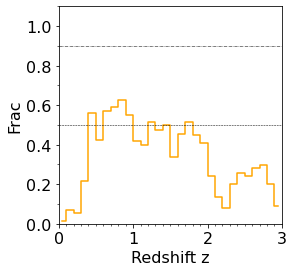

17197
6762
83507
17197


In [55]:
sample_info1 = sample_numbers4(all_match_clean_tbl, sn_key='SN001', sn=6.5, sigma_dz=0.005, 
                               alpha=0.7, bin_size=0.1, zmin=0, zmax=3)

all_match_clean_sn65_tbl, all_match_clean_sn65_dz005_tbl, filts  = sample_info1
all_filt, all_dz_filt = filts

print(len(all_match_clean_sn65_tbl))
print(len(all_match_clean_sn65_dz005_tbl))
print(len(all_filt))      # SN and z filt
print(len(all_dz_filt))   # dz filt

30
All sources = 83507

Num. sources (S/N > 6.5, 0.0 < z < 3.0) = 17197
Num. sources (dz < 0.005) = 6762

30
[ 154  237  201  144   96  168  334  447  604  881 1244  737  821  875
  879 1183 1389 1086  890  797  419  331  359  417  473  492  436  406
  421  276]
[  2  16  11  31  54  71 190 264 378 484 522 293 423 414 439 401 634 558
 399 326 102  45  29  85 121 119 122 120  84  25]
[0.01298701 0.06751055 0.05472637 0.21527778 0.5625     0.42261905
 0.56886228 0.59060403 0.62582781 0.54937571 0.41961415 0.39755767
 0.51522533 0.47314286 0.49943117 0.33896872 0.45644348 0.51381215
 0.44831461 0.40903388 0.24343675 0.13595166 0.08077994 0.20383693
 0.25581395 0.24186992 0.27981651 0.2955665  0.19952494 0.09057971]
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3. ]
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3. ]
17197
6762


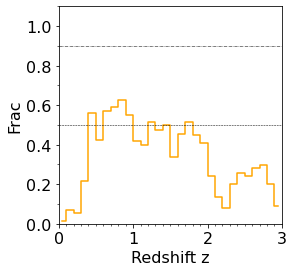

17197
6762
83507
17197
17197
10435

First histogram here:
[152. 221. 190. 113.  42.  97. 144. 183. 226. 397. 722. 444. 398. 461.
 440. 782. 755. 528. 491. 471. 317. 286. 330. 332. 352. 373. 314. 286.
 337. 251.] [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3. ]
10435.0
Second histogram here:
[  2.  16.  11.  31.  54.  71. 190. 264. 378. 484. 522. 293. 423. 414.
 439. 401. 634. 558. 399. 326. 102.  45.  29.  85. 121. 119. 122. 120.
  84.  25.] [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3. ]
6762.0

All sources = 83507

Num. sources (S/N > 6.5, 0.0 < z < 3.0) = 17197
Num. sources (dz < 0.005) = 6762

30
[ 154  237  201  144   96  168  334  447  604  881 1244  737  821  875
  879 1183 1389 1086  890  797  419  331  359  417  473  492  436  406
  421  276]
[  2  16  11  31  54  71 190 264 378 484 522 293 423 414 439 401 634 558
 399 326

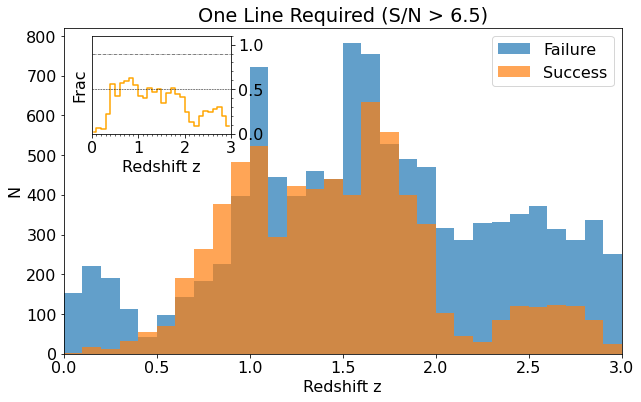

In [56]:
zmin = 0.0
zmax = 3.0
#zmax = 3.0

zinc = 0.1
bins = int((zmax-zmin)/zinc)
print(bins)

#######################

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

sample_info1 = sample_numbers4(all_match_clean_tbl, sn_key='SN001', sn=6.5, sigma_dz=0.005, 
                               alpha=0.7, bin_size=0.1, zmin=0, zmax=3)

all_match_clean_sn65_tbl, all_match_clean_sn65_dz005_tbl, filts  = sample_info1
all_sn65_filt, all_sn65_dz_filt = filts

print(len(all_match_clean_sn65_tbl))
print(len(all_match_clean_sn65_dz005_tbl))
print(len(all_filt))      # SN and z filt
print(len(all_dz_filt))   # dz filt

all_sn65_dz_not_filt = np.logical_not(all_sn65_dz_filt)
all_match_clean_sn65_not_tbl = all_match_clean_sn65_tbl[all_sn65_dz_not_filt]
print(len(all_match_clean_sn65_tbl))
print(len(all_match_clean_sn65_not_tbl))
print()


fig = plt.figure(figsize=(10,6))

p = fig.add_subplot(111)
print("First histogram here:")
n,nbins,patches = p.hist(all_match_clean_sn65_not_tbl["REDSHIFT"],
       range=(zmin,zmax), bins=bins, alpha=0.7, label="Failure")
#n,nbins,patches = p.hist(all_match_clean_sn65_tbl["REDSHIFT"],
#       range=(zmin,zmax), bins=bins, alpha=0.7, label="All")
print(n,nbins)
print(np.sum(n))

print("Second histogram here:")
n,nbins,patches = p.hist(all_match_clean_sn65_dz005_tbl["REDSHIFT"],
       range=(zmin,zmax), bins=bins, alpha=0.7, label="Success")
print(n,nbins)
print(np.sum(n))

#p.legend()

p.set_xlabel("Redshift z")
p.set_ylabel("N")
p.set_xlim(zmin,zmax)
p.set_title("One Line Required (S/N > 6.5)")
#p.set_ylim(0,30)
p.xaxis.set_major_locator(MultipleLocator(0.5))

p.legend()

# Create inset in data coordinates using ax.transData as transform
ax_ins = inset_axes(p, width="100%", height="100%",
                    #bbox_to_anchor=(0.68, 0.48, 0.25, 0.3),
                    bbox_to_anchor=(0.05, 0.675, 0.25, 0.3),
                    bbox_transform=p.transAxes, borderpad=0)

ax_ins.tick_params(which='both',left=False, right=True, labelleft=False, labelright=True)

print()
sample_info1 = sample_numbers4(all_match_clean_tbl, sn_key='SN001', sn=6.5, sigma_dz=0.005, 
                               alpha=0.7, bin_size=zinc, zmin=zmin, zmax=zmax, ax=ax_ins)
    

#all_match_clean_sn65_tbl, all_match_clean_sn65_dz005_tbl, filts = sample_info1
#all_filt, all_dz_filt = filts

#print(len(all_match_clean_sn65_tbl))
#print(len(all_match_clean_sn65_dz005_tbl))
#print(len(all_filt))      # SN and z filt
#print(len(all_dz_filt))   # dz filt

plt.show()

30
All sources = 17197

Num. sources (S/N > 3.0, 0.0 < z < 3.0) = 7898
Num. sources (dz < 0.005) = 4750

30
[ 47  62  43  40  49  72 173 211 258 316 718 300 357 364 409 711 899 593
 479 411 141  93 113 147 149 164 152 166 173  88]
[  2  15   9  23  37  53 151 190 231 261 249 128 254 271 325 303 538 493
 370 278  60  25  16  52  79  76  87  91  60  23]
[0.04255319 0.24193548 0.20930233 0.575      0.75510204 0.73611111
 0.87283237 0.90047393 0.89534884 0.82594937 0.34679666 0.42666667
 0.71148459 0.74450549 0.79462103 0.42616034 0.59844271 0.83136594
 0.77244259 0.67639903 0.42553191 0.2688172  0.14159292 0.3537415
 0.53020134 0.46341463 0.57236842 0.54819277 0.34682081 0.26136364]
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3. ]
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3. ]
7898
4750


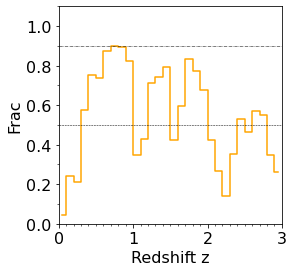

7898
4750
83507
17197

7898
3148

First histogram here:
[ 45.  47.  34.  17.  12.  19.  22.  21.  27.  55. 469. 172. 103.  93.
  84. 408. 361. 100. 109. 133.  81.  68.  97.  95.  70.  88.  65.  75.
 113.  65.] [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3. ]
3148.0
Second histogram here:
[  2.  15.   9.  23.  37.  53. 151. 190. 231. 261. 249. 128. 254. 271.
 325. 303. 538. 493. 370. 278.  60.  25.  16.  52.  79.  76.  87.  91.
  60.  23.] [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3. ]
4750.0

All sources = 17197

Num. sources (S/N > 3.0, 0.0 < z < 3.0) = 7898
Num. sources (dz < 0.005) = 4750

30
[ 47  62  43  40  49  72 173 211 258 316 718 300 357 364 409 711 899 593
 479 411 141  93 113 147 149 164 152 166 173  88]
[  2  15   9  23  37  53 151 190 231 261 249 128 254 271 325 303 538 493
 370 278  60  25  16  52  79  76  87  91  6

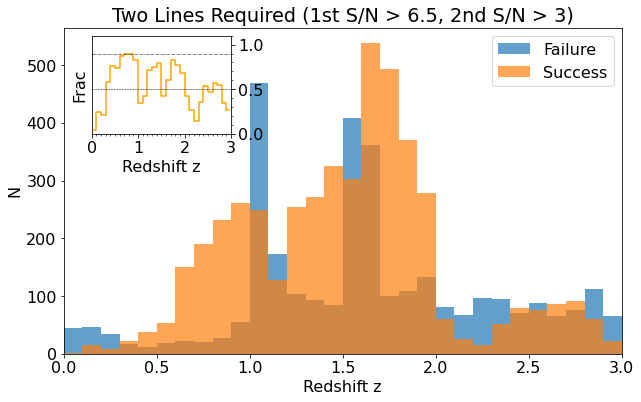

In [57]:
zmin = 0.0
zmax = 3.0
#zmax = 3.0

zinc = 0.1
bins = int((zmax-zmin)/zinc)
print(bins)

#######################

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

sample_info1 = sample_numbers4(all_match_clean_sn65_tbl, sn_key='SN002', sn=3.0, sigma_dz=0.005, 
                               alpha=0.7, bin_size=0.1, zmin=0, zmax=3)

all_match_clean_sn65_sn3_tbl, all_match_clean_sn65_sn3_dz005_tbl, filts  = sample_info1
all_sn3_filt, all_sn3_dz_filt = filts

print(len(all_match_clean_sn65_sn3_tbl))
print(len(all_match_clean_sn65_sn3_dz005_tbl))
print(len(all_filt))      # SN and z filt
print(len(all_dz_filt))   # dz filt
print()

all_sn3_dz_not_filt = np.logical_not(all_sn3_dz_filt)
all_match_clean_sn65_sn3_not_tbl = all_match_clean_sn65_sn3_tbl[all_sn3_dz_not_filt]
print(len(all_match_clean_sn65_sn3_tbl))
print(len(all_match_clean_sn65_sn3_not_tbl))
print()


fig = plt.figure(figsize=(10,6))

p = fig.add_subplot(111)
print("First histogram here:")
n,nbins,patches = p.hist(all_match_clean_sn65_sn3_not_tbl["REDSHIFT"],
       range=(zmin,zmax), bins=bins, alpha=0.7, label="Failure")
#n,nbins,patches = p.hist(all_match_clean_sn65_tbl["REDSHIFT"],
#       range=(zmin,zmax), bins=bins, alpha=0.7, label="All")
print(n,nbins)
print(np.sum(n))

print("Second histogram here:")
n,nbins,patches = p.hist(all_match_clean_sn65_sn3_dz005_tbl["REDSHIFT"],
       range=(zmin,zmax), bins=bins, alpha=0.7, label="Success")
print(n,nbins)
print(np.sum(n))

#p.legend()

p.set_xlabel("Redshift z")
p.set_ylabel("N")
p.set_xlim(zmin,zmax)
p.set_title("Two Lines Required (1st S/N > 6.5, 2nd S/N > 3)")
#p.set_ylim(0,30)
p.xaxis.set_major_locator(MultipleLocator(0.5))

p.legend()

# Create inset in data coordinates using ax.transData as transform
ax_ins = inset_axes(p, width="100%", height="100%",
                    #bbox_to_anchor=(0.68, 0.48, 0.25, 0.3),
                    bbox_to_anchor=(0.05, 0.675, 0.25, 0.3),
                    bbox_transform=p.transAxes, borderpad=0)

ax_ins.tick_params(which='both',left=False, right=True, labelleft=False, labelright=True)

print()
sample_info1 = sample_numbers4(all_match_clean_sn65_tbl, sn_key='SN002', sn=3.0, sigma_dz=0.005, 
                               alpha=0.7, bin_size=zinc, zmin=zmin, zmax=zmax, ax=ax_ins)
    
#all_match_clean_sn65_tbl, all_match_clean_sn65_dz005_tbl, filts = sample_info1
#all_filt, all_dz_filt = filts

#print(len(all_match_clean_sn65_tbl))
#print(len(all_match_clean_sn65_dz005_tbl))
#print(len(all_filt))      # SN and z filt
#print(len(all_dz_filt))   # dz filt

plt.show()

In [ ]:
fig = plt.figure(figsize=(12,5))

p1 = fig.add_subplot(111)
#p1.hist(dz,bins=100)

p1.hist(dz,bins=200)
#p1.set_xlim(-0.02,0.02)

p1.set_xlabel("dz")

In [ ]:
# Everything that it thinks has a line
#emline_bar_chart2(all_match_clean_tbl['LINE001'],all_match_clean_sn65_dz005_tbl['LINE001'], 
#                  title = "1st brightest line")

# Require 1 line (S/N > 6.5)
emline_bar_chart2(all_match_clean_sn65_tbl['LINE001'],all_match_clean_sn65_dz005_tbl['LINE001'], 
                  title = "1st brightest line")

# Require 2 lines (1st line S/N > 6.5 and a 2nd line S/N > 3.0)
emline_bar_chart2(all_match_clean_sn65_dz005_tbl['LINE001'],all_match_clean_sn65_sn3_dz005_tbl['LINE001'], 
                  title = "1st brightest line")
emline_bar_chart2(all_match_clean_sn65_dz005_tbl['LINE002'],all_match_clean_sn65_sn3_dz005_tbl['LINE002'], 
                  title = "2nd brightest line")

#emline_bar_chart(all_match_clean_tbl['LINE001'],title = "1st brightest line")
#emline_bar_chart(all_match_clean_tbl['LINE002'],title = "2nd brightest line")
#emline_bar_chart(all_match_clean_tbl['LINE003'],title = "3rd brightest line")
#emline_bar_chart(all_match_clean_tbl['LINE004'],title = "4th brightest line")
#emline_bar_chart(all_match_clean_tbl['LINE005'],title = "5th brightest line")

In [ ]:
print("All sources")
print(len(all_match_tbl))
print()

print("Sources matched with a radius <0.4")
#clean_filt
all_match_clean_tbl
print(len(all_match_clean_tbl))

#all_clean_not_filt = np.logical_not(all_clean_filt)
#all_match_clean_not_tbl = all_match_tbl[all_clean_not_filt]
#print(len(all_match_clean_not_tbl))
print()

print("Sources with line S/N > 6.5")
all_sn65_filt
all_match_clean_sn65_tbl
print(len(all_match_clean_sn65_tbl))

all_sn65_not_filt = np.logical_not(all_sn65_filt)
all_match_clean_sn65_not_tbl = all_match_clean_tbl[all_sn65_not_filt]
print(len(all_match_clean_sn65_not_tbl))
print()

print("Sources with line S/N > 6.5 within z < 0.005*(1+z)")
all_sn65_dz005_filt
all_match_clean_sn65_dz005_tbl
print(len(all_match_clean_sn65_dz005_tbl))

all_sn65_dz005_not_filt = np.logical_not(all_sn65_dz005_filt)
all_match_clean_sn65_dz005_not_tbl = all_match_clean_sn65_tbl[all_sn65_dz005_not_filt]
print(len(all_match_clean_sn65_dz005_not_tbl))

In [ ]:
print(os.getcwd())

In [ ]:
#all_match_tbl.write("match.fits")
#all_match_clean_tbl.write("match_clean.fits") # on the order of MB 

In [ ]:
sn_dz_plot(all_match_clean_tbl)

In [ ]:
sn_dz_hist2d_plot(all_match_clean_tbl)

In [ ]:
#print(all_match_clean_tbl['id'])
#print(all_match_clean_sn65_tbl['id'])
print(all_match_clean_sn65_dz005_tbl['id'])

In [ ]:
#print(all_match_clean_not_tbl['id'])
#print(all_match_clean_sn65_not_tbl['id'])
print(all_match_clean_sn65_dz005_not_tbl['id'])

In [ ]:
fig = plt.figure(figsize=(10,6))
p = fig.add_subplot(111)
#p.hist(all_match_clean_sn65_dz005_not_tbl['MAG_F1600W'],
#       range=(16,32), bins=16*5, alpha=0.7, label="failures")
#p.hist(all_match_clean_sn65_dz005_tbl['MAG_F1600W'],
#       range=(16,32), bins=16*5, alpha=0.7, label="matches")
p.hist(all_match_clean_sn65_dz005_not_tbl['m_new'],
       range=(16,32), bins=16*5, alpha=0.7, label="failures")
p.hist(all_match_clean_sn65_dz005_tbl['m_new'],
       range=(16,32), bins=16*5, alpha=0.7, label="success")
p.legend()

In [ ]:
mag_cut = 24

print("All sources")
print(len(all_match_tbl))
filt = all_match_tbl['MAG_AUTO'] < mag_cut
print("Sources m < %i" % (mag_cut))
print(len(all_match_tbl[filt]))
print()

print("Sources matched with a radius <0.4")
#clean_filt
#all_match_clean_tbl
print(len(all_match_clean_tbl))
filt = all_match_clean_tbl['MAG_AUTO'] < mag_cut
print("Sources m < %i" % (mag_cut))
print(len(all_match_clean_tbl[filt]))
print()

print("Sources with line S/N > 6.5")
print(len(all_match_clean_sn65_tbl))
filt = all_match_clean_sn65_tbl['MAG_AUTO'] < mag_cut
print("Sources m < %i" % (mag_cut))
print(len(all_match_clean_sn65_tbl[filt]))
print()

#print(len(all_match_clean_sn65_not_tbl))
#filt = all_match_clean_sn65_not_tbl['MAG_AUTO'] < mag_cut
#print(len(all_match_clean_sn65_not_tbl[filt]))
#print()

print("Sources with line S/N > 6.5 within z < 0.005*(1+z)")
print(len(all_match_clean_sn65_dz005_tbl))
filt = all_match_clean_sn65_dz005_tbl['MAG_AUTO'] < mag_cut
print("Sources m < %i" % (mag_cut))
print(len(all_match_clean_sn65_dz005_tbl[filt]))
print()

#print(len(all_match_clean_sn65_dz005_not_tbl))
#filt = all_match_clean_sn65_dz005_not_tbl['MAG_AUTO'] < mag_cut
#print(len(all_match_clean_sn65_dz005_not_tbl[filt]))
#print()

In [ ]:
id = 185

tbl = all_match_clean_tbl
filt = tbl['id'] == id

#display_grizli("my_roman_sims", id, w0=0.95, w1=2.0)
display_grizli("sim_v3", id, w0=0.95, w1=2.0, z_in=tbl["z_true"][filt])

print(tbl["MAG_AUTO","REDSHIFT","z_true"][filt])
print(tbl["SN001","LINE001","SN002","LINE002"][filt])

In [ ]:
print(dir())
#print(__dict__)